In [1265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [1266]:
#load data
data = pd.read_csv('train/combined.csv', index_col=0)

X = data.drop(['right_touch', 'left_touch'], axis=1)
y = data[['right_touch', 'left_touch']]

X_train = X
y_train = y

data = pd.read_csv('leg_fix/combined.csv', index_col=0)
# data = pd.read_csv('.csv', index_col=0)
#reset index
data.reset_index(drop=True, inplace=True)

X = data.drop(['right_touch', 'left_touch'], axis=1)
y = data[['right_touch', 'left_touch']]

X_test = X
y_test = y

# Use train_test_split with stratify parameter
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [1267]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch Normalization after the first linear layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)  # Dropout
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.relu(x)
        x = self.dropout(x)  # Apply Dropout
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


input_size = X_train.shape[1]
hidden_size = 64  # You can adjust this based on your problem
output_size = 2  # Assuming binary classification for each foot

# Instantiate the model
model = NN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [1268]:
# Convert data to DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [1269]:
num_epochs = 30

losses = []
val_losses = []


for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation loss
    losses.append(loss.item())
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    # Print the loss for every epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Evaluate the model on the test set
with torch.no_grad():
    # model.eval()
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [5/30], Loss: 0.4255
Epoch [10/30], Loss: 0.1084
Epoch [15/30], Loss: 0.1856
Epoch [20/30], Loss: 0.1331
Epoch [25/30], Loss: 0.2373
Epoch [30/30], Loss: 0.1366
Test Loss: 0.1836


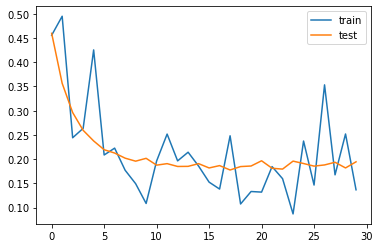

In [1270]:
#plot loss
plt.plot(losses, label='train')
plt.plot(val_losses, label='test')
plt.legend()
plt.show()


In [1271]:
#predict on train set
with torch.no_grad():
    model.eval()
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    print(f'Train Loss: {train_loss.item():.4f}')
    

Train Loss: 0.1105


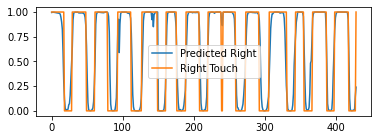

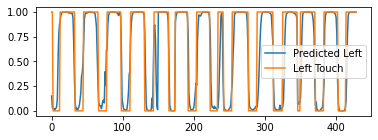

In [1272]:
#predict on full set
X_full = torch.tensor(X_test.values, dtype=torch.float32)
X_full_outputs = model(X_full)
X_np = X_full_outputs.detach().numpy()

#plot output
plt.figure(figsize=(6, 2))
plt.plot(X_np[:, 0], label='Predicted Right')
plt.plot(y.right_touch, label='Right Touch')
plt.legend()

plt.figure(figsize=(6, 2))
plt.plot(X_np[:, 1], label='Predicted Left')
plt.plot(y.left_touch, label='Left Touch')
plt.legend()
plt.show()


In [1273]:
#get accuracy on test set
y_pred = np.round(X_np)
y_actual = y_test.values
# print(y_pred)
# print(y_actual)
print(np.sum(y_pred == y_actual) / y_actual.size)

0.9300699300699301


In [1274]:
#get baseline accuracy
y_baseline = np.ones(y_actual.shape)
print(np.sum(y_baseline == y_actual) / y_actual.size)

0.627039627039627


In [1275]:
#round predictions
X_full_outputs_round = torch.round(X_full_outputs)

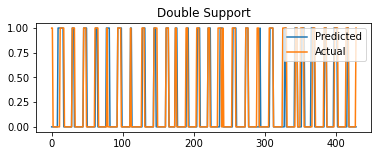

In [1276]:
#calculate double support by looking at when both feet are touching (1,1)
ds = []
for i in range(len(X_full_outputs_round)):
    if X_full_outputs_round[i][0] == 1 and X_full_outputs_round[i][1] == 1:
        ds.append(1)
    else:
        ds.append(0)

ds_true = []
for i in range(len(y)):
    if y.right_touch[i] == 1 and y.left_touch[i] == 1:
        ds_true.append(1)
    else:
        ds_true.append(0)

#plot double support
plt.figure(figsize=(6, 2))
plt.plot(ds, label='Predicted')
plt.plot(ds_true, label='Actual')
plt.legend()
plt.title('Double Support')
plt.show()

In [1277]:
#calculate percentege of 1s in predictions
print('Predicted Double Support:', sum(ds)/len(ds))
print('Actual Double Support:', sum(ds_true)/len(ds_true))

Predicted Double Support: 0.23543123543123542
Actual Double Support: 0.2540792540792541


In [1278]:
#save the model
# torch.save(model.state_dict(), 'model.pt')